In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import timedelta
import sys
sys.path.insert(0, '/glade/u/home/acheung/TCGenesisIndex/Scripts')
from useful_functions import era_5_datestrings,generate_pathstrs,run_sample_dataset_2, week_to_month
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
import os

In [2]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
import dask
# Change your url to the dask dashboard so you can see it

cluster = NCARCluster(project='UMCP0022')
cluster.adapt(minimum_jobs=1, maximum_jobs=60)
client = Client(cluster)
client


/glade/u/home/acheung/.conda/envs/picalc/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44530 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acheung/proxy/44530/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acheung/proxy/44530/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.49:44269,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acheung/proxy/44530/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Calculate Potential Intensity

Variables needed for input: 

1. SSTC: Sea surface temperature (C)
2. MSL: Mean Sea level pressure (hPa)
3. P,TC,R: One-dimensional arrays 
             containing pressure (hPa), temperature (C),
             and mixing ratio (g/kg). The arrays MUST be
             arranged so that the lowest index corresponds
             to the lowest model level, with increasing index
             corresponding to decreasing pressure. The temperature
             sounding should extend to at least the tropopause and 
             preferably to the lower stratosphere, however the
             mixing ratios are not important above the boundary
             layer. Missing mixing ratios can be replaced by zeros

In [6]:
first_year = 2001

# Need to simulate week by week, so we do pressure level strings first, which are daily files
data_interval = 1 # days
date_range_list_pl = era_5_datestrings(data_interval,'pl',first_year)

# Generate T file path strings

T_var_id = '130_t'
T_path_strs = generate_pathstrs(date_range_list_pl,T_var_id,'sc','pl')

# Generate specific humidity (q) file path strings

q_var_id = '133_q'
q_path_strs = generate_pathstrs(date_range_list_pl,q_var_id,'sc','pl')

iteration = 1
# for i in range(0,len(date_range_list_pl),data_interval):
for i in range(0,1,data_interval):
    start = time.time()

    # Find out what week we are working with here
    week_start_dt = date_range_list_pl[i]
    if i + data_interval >= len(date_range_list_pl):
        week_end_dt = date_range_list_pl[-1]
    else:
        week_end_dt = date_range_list_pl[i+data_interval]
    
    # Find the string needed to open a monthly file for the week for sst
    path_strs_needed_sst = week_to_month(week_start_dt,week_end_dt,'034_sstk','sc')

    # Grab SST (degrees C)

    SSTK_pre = xr.open_mfdataset(path_strs_needed_sst,parallel=True)
    SSTK = SSTK_pre.sel(time=slice(week_start_dt,week_end_dt-timedelta(hours=1))).mean('time')
    
    SSTK.coords['longitude'] = (SSTK.coords['longitude'] + 180) % 360 - 180
    SSTK = SSTK.sortby(SSTK.longitude)
    SSTC = SSTK - 273.15
    SSTC = SSTC.assign_coords({"beg":week_start_dt})
    SSTC = SSTC.assign_coords({"end":week_end_dt-timedelta(hours=1)})
    SSTC = SSTC.drop_vars('utc_date')
    
    # Grab Temperature Soundings
    
    T = xr.open_mfdataset(T_path_strs[i:i+data_interval],parallel=True,chunks={'time': 14}).mean('time')
    T = T.reindex(level=list(reversed(T.level))) - 273.15
    T.coords['longitude'] = (T.coords['longitude'] + 180) % 360 - 180
    T = T.sortby(T.longitude)
    T = T.assign_coords({"beg":week_start_dt})
    T = T.assign_coords({"end":week_end_dt-timedelta(hours=1)})
    T = T.drop_vars('utc_date')
    # Grab MSL
    
    path_strs_needed_msl = week_to_month(week_start_dt,week_end_dt,'151_msl','sc')

    msl_pre = xr.open_mfdataset(path_strs_needed_msl) # Units: Pa
    msl = msl_pre.sel(time=slice(week_start_dt,week_end_dt-timedelta(hours=1))).mean('time')
    msl.coords['longitude'] = (msl.coords['longitude'] + 180) % 360 - 180
    msl = msl.sortby(msl.longitude)
    msl = msl/100 # Units: hPa
    msl = msl.assign_coords({"beg":week_start_dt})
    msl = msl.assign_coords({"end":week_end_dt-timedelta(hours=1)})
    msl = msl.drop_vars('utc_date')

    # Grab Mixing Ratio (g/kg)

    # ASSUMPTION! In the sample data, specific humidity is assumed to be approximately equal to mixing ratio (r), since r/(1+r) = q and r << 1
    
    q = xr.open_mfdataset(q_path_strs[i:i+data_interval],parallel=True,chunks={'time': 14}).mean('time') # Units: kg/kg
    q.coords['longitude'] = (q.coords['longitude'] + 180) % 360 - 180
    q = q.sortby(q.longitude)
    q = q.reindex(level=list(reversed(q.level)))
    
    # Convert to g/kg
    q = q * 1000 # Units: g/kg
    q = q.assign_coords({"beg":week_start_dt})
    q = q.assign_coords({"end":week_end_dt-timedelta(hours=1)})
    q = q.drop_vars('utc_date')

    # total time taken
    current_strs_for_saving = T_path_strs[i:i+data_interval]

    variable_file_name_start_time = current_strs_for_saving[0][89:100]
    variable_file_name_end_time = current_strs_for_saving[-1][100:]

    var_file_name_full = "PI_" + variable_file_name_start_time + variable_file_name_end_time
    
    merged = xr.merge([SSTC,T,msl,q],compat='override')
    # merged.to_netcdf(f'/glade/scratch/acheung/intermediate/PI/merged{variable_file_name_start_time + variable_file_name_end_time}.nc')

    ds_1 = run_sample_dataset_2(merged)
    
    path = "/glade/scratch/acheung/PI/"
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
    # Create a new directory because it does not exist
        os.makedirs(path) 

    ds_1['vmax'].to_netcdf(path + var_file_name_full)
    print('...PI computation complete and saved\n')

    end = time.time()
    print(f"Runtime of day {iteration} of {len(np.arange(0,len(T_path_strs),data_interval))} is {round(end - start,2)} s")
    print(f"Predicted Time Remaining: {round((end - start) * (len(np.arange(0,len(T_path_strs),data_interval)) - iteration)/3600,2)} h")
    iteration = iteration + 1

...PI computation complete and saved

Runtime of day 1 of 365 is 147.31 s
Predicted Time Remaining: 14.89 h


In [11]:
letssee = xr.open_dataset('/glade/scratch/acheung/PI/PI_1980010100_1980010123.nc')
letssee

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    beg        datetime64[ns] ...
    end        datetime64[ns] ...
Data variables:
    vmax       (latitude, longitude) float64 ...

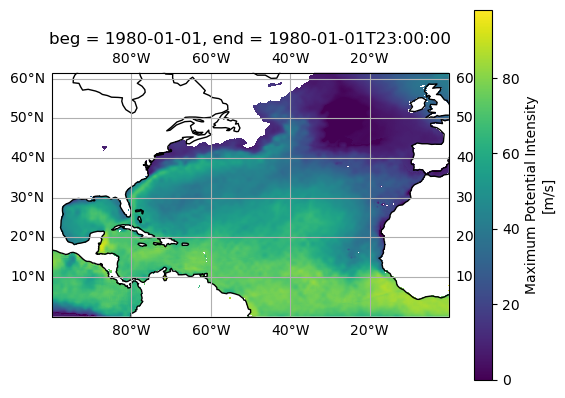

In [10]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 50])
(letssee['vmax']).plot()

In [ ]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 50])
xr.open_dataset('data/full_sample_output.nc')['q'][0,0].plot()

In [ ]:
ds = xr.open_dataset('/glade/work/acheung/data/sample_data.nc')

In [ ]:
ds['msl'][0].plot()

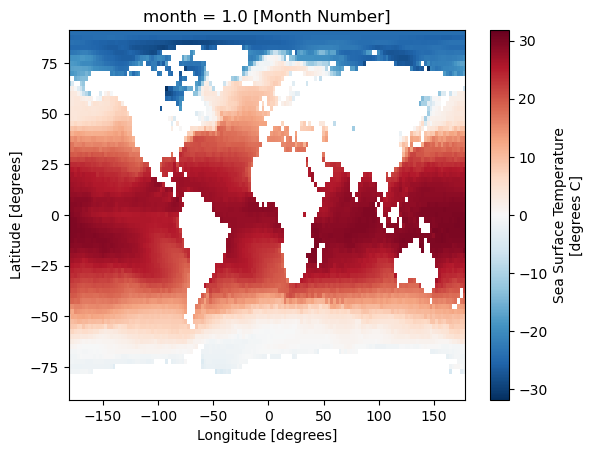

In [17]:
ds['sst'][0].plot()

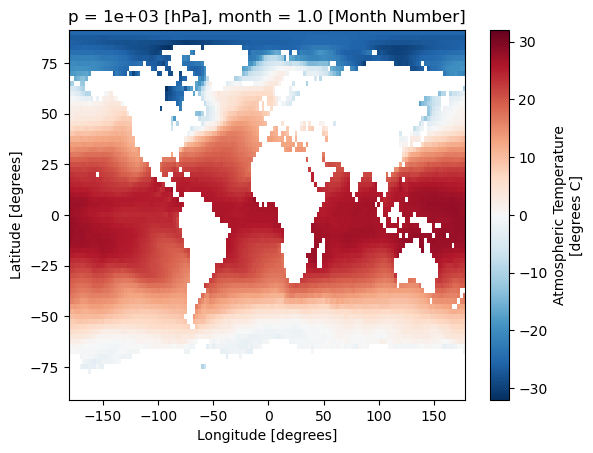

In [18]:
ds['t'][0][0].plot()

In [19]:
ds['p']

<xarray.DataArray 'p' (p: 31)>
array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
        750.,  725.,  700.,  650.,  600.,  550.,  500.,  450.,  400.,  350.,
        300.,  250.,  200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,
         10.])
Coordinates:
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 40.0 30.0 20.0 10.0
Attributes:
    standard_name:  Atmospheric Pressure
    units:          hPa

In [20]:
ds

<xarray.Dataset>
Dimensions:  (p: 31, lat: 73, lon: 144, month: 12)
Coordinates:
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 40.0 30.0 20.0 10.0
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * month    (month) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    lsm      (lat, lon) float64 ...
    sst      (month, lat, lon) float64 ...
    msl      (month, lat, lon) float64 ...
    t        (month, p, lat, lon) float64 ...
    q        (month, p, lat, lon) float64 ...
    Vmax     (month, lat, lon) float64 ...
    To       (month, lat, lon) float64 ...
    Pmin     (month, lat, lon) float64 ...
    LNB      (month, lat, lon) float64 ...
    PI_flag  (month, lat, lon) float64 ...

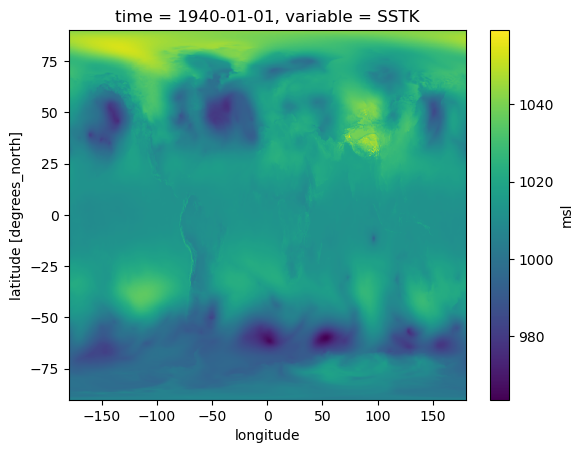

In [21]:
xr.open_dataset('/glade/u/home/acheung/TC_Genesis_Index/Scripts/ERA5 Processing/merged.nc')['msl'].plot()